In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json
from decimal import Decimal

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

colors['Fasted'] = colors['FBG']
colors['Random-fed'] = colors['RBG']
colors['Fed'] = colors['RBG']
colors['Fasted'] = colors['FBG']

In [29]:
lasso = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\LASSO.csv', index_col=0)
rf = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\random_forest.csv', index_col=0)
svr = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\svr.csv', index_col=0)

In [271]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', 
                index_col=0).rename({'x': 'Feeding'}, axis=1)
r['model'] = r['model'].map({'ols': 'OLS', 'lasso': 'LASSO (L1)', 'ridge': 'Ridge (L2)', 
                                   'svm': 'SVM\n(Linear kernel)', 'pls': 'PLS', 'rf': 'Random\nForest',
                                   'xgboost': 'XGBoost'})
mse = r.melt(value_vars=r.filter(regex='neg_mean_squared_error_\d').columns, id_vars=['model', 'Feeding', 'y']) \
        .drop('variable', axis=1)
r2 = r.melt(value_vars=r.filter(regex='r2_\d').columns, id_vars=['model', 'Feeding', 'y']) \
        .drop('variable', axis=1)
mape = r.melt(value_vars=r.filter(regex='neg_mean_absolute_percentage_error_\d').columns, 
              id_vars=['model', 'Feeding', 'y']).drop('variable', axis=1)
mae = r.melt(value_vars=r.filter(regex='neg_mean_absolute_error_\d').columns, 
              id_vars=['model', 'Feeding', 'y']).drop('variable', axis=1)
ogtt = melt.loc[melt['y'] == 'ogtt'].drop('y', axis=1)
insulin = melt.loc[melt['y'] == 'insulin'].drop('y', axis=1)
weight = melt.loc[melt['y'] == 'weight'].drop('y', axis=1)

# Examples of other plots: catplot, stripplot, boxplot, boxenplot, histplot

## Boxplot overall looks good and will be good for `r2` with its crazy low outliers 

<AxesSubplot:xlabel='value', ylabel='model'>

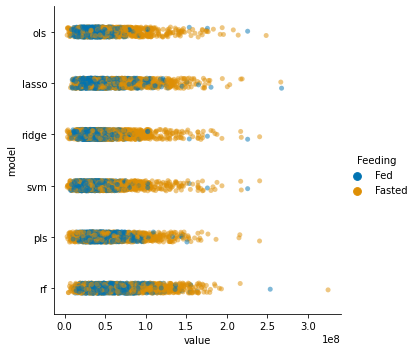

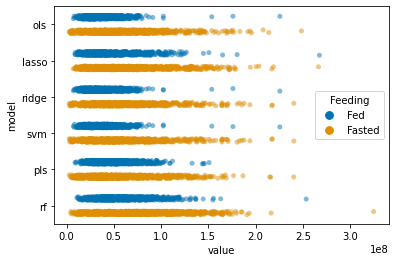

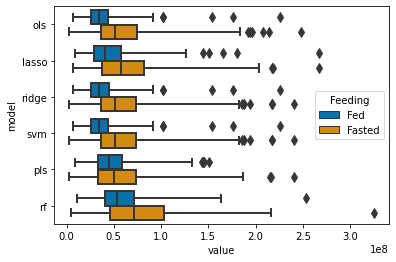

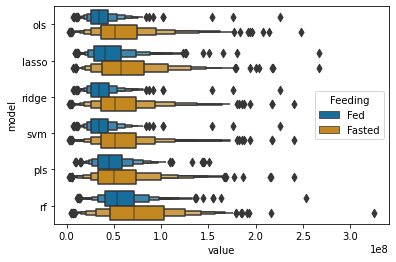

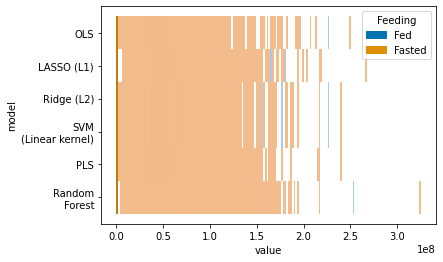

In [303]:
vp = sns.catplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Feeding',
#     dodge=True,
    palette=colors, alpha=0.5,)
plt.figure()
vp = sns.stripplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Feeding',
    dodge=True,
    palette=colors, alpha=0.5)
plt.figure()
vp = sns.boxplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Feeding',
    width=0.8,
    linewidth=2,
    fliersize=7, whis=3,
#     scale='width',
    palette=colors, saturation=0.9,)
plt.figure()
vp = sns.boxenplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Feeding',
#     scale='width',
    palette=colors, )
plt.figure()
sns.histplot(
    data=mse, x='value', y='model',
    hue='Feeding', palette=colors,)

(0.0, 1.0)

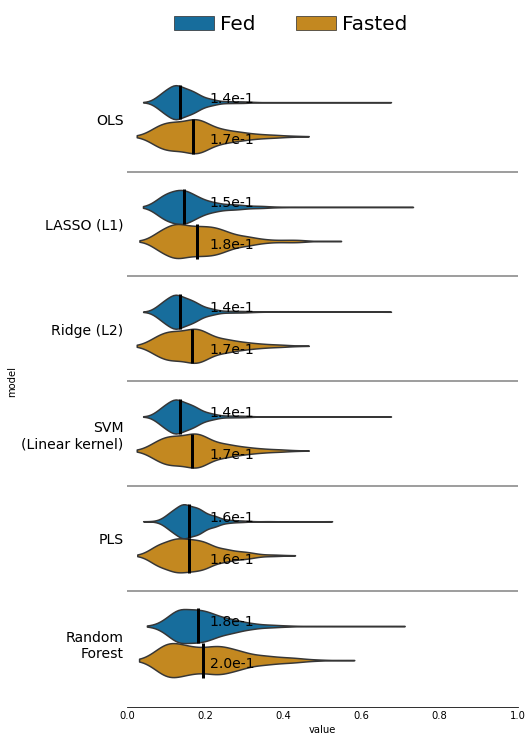

In [235]:
def plot_comparison(y, error, cut=0.4, width=0.65, 
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, 
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Feeding', 'y']) \
           .drop('variable', axis=1)
    fig, ax = plt.subplots(figsize=(7, 12))
    vp = sns.violinplot(
        data=df, x='value', y='model',
        orient='h', split=split, hue='Feeding', 
        scale='width', cut=cut, width=width,
        palette=colors, inner=None, ax=ax, **kwargs)
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Fed', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Feeding'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            ax.plot([error_median, error_median], [i, i + direction*0.33], linewidth=3, color='black', solid_capstyle='butt')
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
            ax.annotate(error_median, xy=(x_point, i + direction*0.2), 
                         ha='center', va='center', fontsize=14)
    plt.yticks(fontsize=14)
#     plt.xlim(plt.xlim()[0], plt.xlim()[1]*0.8)
    for y in np.arange(0.5, 5, 1):
        plt.axhline(y=y, color='gray')
    plt.tick_params(axis='both', length=0)
    # plt.grid(axis='x', visible=None, ) 
    # ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
    sns.despine(left=True)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)
plot_comparison(y='ogtt', error='neg_mean_absolute_percentage_error', split=False)
plt.xlim(0, 1)

## It's difficult to get the `r2` plot looking good because it goes from -10 to 1.0

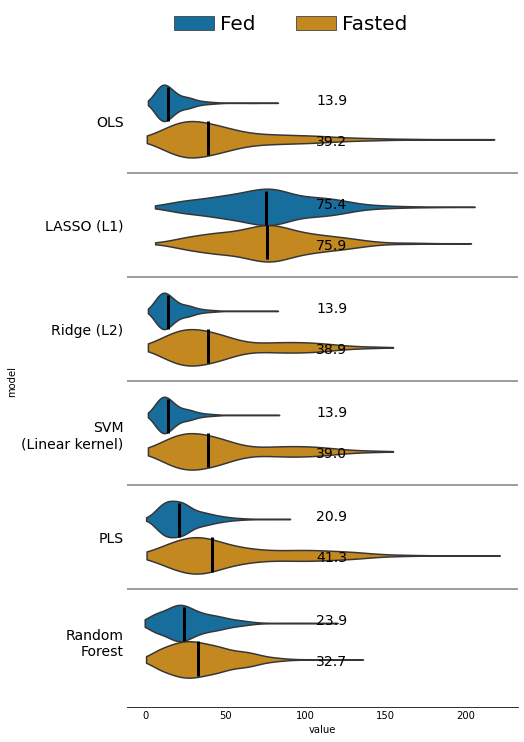

In [241]:
plot_comparison(y='weight', error='neg_mean_squared_error',
                width=0.7, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=False, round_decimal=1,
                split=False)
# plt.xlim(-0.1, 1.1)

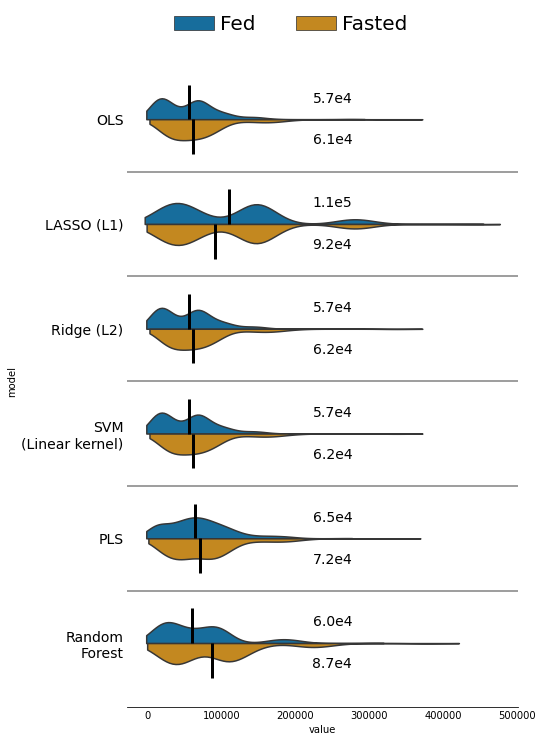

In [231]:
plot_comparison(y='insulin', error='neg_mean_squared_error',
                width=0.4, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=True)

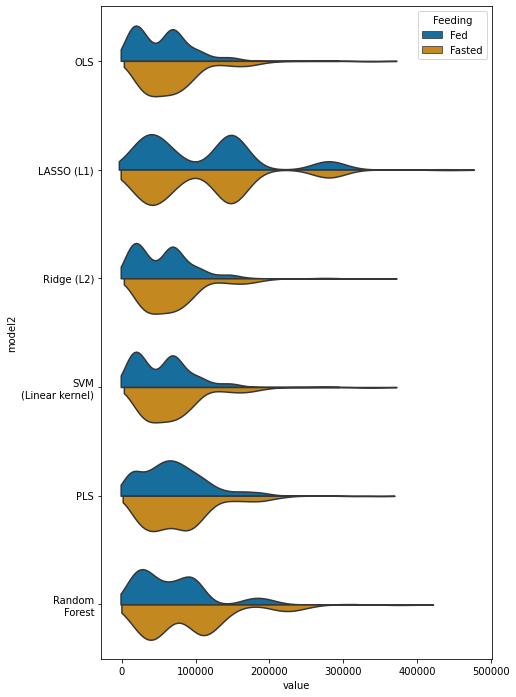

In [129]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=insulin, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

In [7]:
lasso['model'] = 'lasso'
rf['model'] = 'rf'
svr['model'] = 'model'
concat = pd.concat([lasso, rf, svr])
concat['Feeding'] = concat['variable'].map({'FBG': 'Fasted', 'RBG': 'Random-fed'})
concat

,variable,value,dummy,model,Feeding
0,FBG,0.376486,dummy,lasso,Fasted
1,FBG,0.194368,dummy,lasso,Fasted
2,FBG,0.286964,dummy,lasso,Fasted
3,FBG,0.366897,dummy,lasso,Fasted
4,FBG,0.168847,dummy,lasso,Fasted
...,...,...,...,...,...
595,RBG,0.161203,dummy,model,Random-fed
596,RBG,0.153347,dummy,model,Random-fed
597,RBG,0.122726,dummy,model,Random-fed
598,RBG,0.461233,dummy,model,Random-fed


In [98]:
d = {}
for df, name in zip([lasso, rf, svr], ['lasso', 'rf', 'svr']):
    d[name] = {}
    d[name]['rbg_mean'] = df.loc[df['variable'] == 'RBG', 'value'].mean()
    d[name]['fbg_mean'] = df.loc[df['variable'] == 'FBG', 'value'].mean()

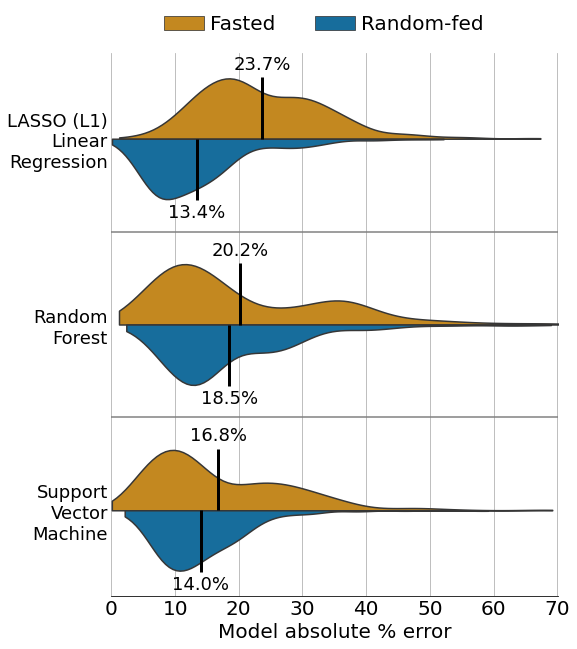

In [111]:
fig, ax = plt.subplots(figsize=(8, 10))

vp = sns.violinplot(
    data=concat, x='value', y='model',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(['lasso', 'rf', 'svr']):
    fbg_mean = d[model]['fbg_mean']
    rbg_mean = d[model]['rbg_mean']
    plt.plot([fbg_mean, fbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean*100, 1)) + '%', xy=(fbg_mean, i - 0.4), ha='center', va='center', fontsize=18)
    plt.annotate(str(round(rbg_mean*100, 1)) + '%', xy=(rbg_mean, i + 0.4), ha='center', va='center', fontsize=18)
plt.axhline(y=0.5, color='gray')
plt.axhline(y=1.5, color='gray')
plt.xlim(0, 0.701)
plt.xticks(ticks=plt.xticks()[0][:-1], labels=[str(x) for x in range(0, 80, 10)], fontsize=20)
plt.xlabel('Model absolute % error', fontsize=20)
# plt.ylabel('Model', fontsize=18)
plt.ylabel(None)
plt.yticks(ticks=[0,1,2], 
           labels=['LASSO (L1)\nLinear\nRegression', 'Random\nForest', 'Support\nVector\nMachine'],
           fontsize=18, ha='right')
plt.tick_params(axis='both', length=0)
plt.grid(axis='x', visible=None, ) 
ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True, bottom=False)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
vp = sns.violinplot(
data=errors, x='value', y='dummy',
orient='h', split=True, hue='variable',
scale='width', cut=0.4,
palette=colors, 
inner=None, 
ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)
